In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn import metrics
import lightgbm as lgb
import os

In [3]:
%%time
train_full = pd.read_csv("./datasets/cov_filtered_2.5_training.csv",index_col = 0)
validation_full = pd.read_csv("./datasets/cov_filtered_2.5_validation.csv",index_col = 0)
test_full = pd.read_csv("./datasets/cov_filtered_2.5_test.csv",index_col = 0)

# print(train_full.shape) 
# print(validation_full.shape) 

dataset_sizes = pd.read_csv("subset sizes.csv", header = None)

# Labels -> numbers
labels = pd.read_csv("labels.csv")
labels.columns = ["Label", "Cluster"]
labels_dict = {}
for i in range(75):
    labels_dict[labels.iloc[i,1]] = i
train_full["Classification"].replace(labels_dict, inplace=True)
validation_full["Classification"].replace(labels_dict, inplace=True)
test_full["Classification"].replace(labels_dict, inplace=True)

CPU times: user 6.92 s, sys: 1 s, total: 7.92 s
Wall time: 8.07 s


In [4]:
train = train_full
validation = validation_full
test = test_full

In [6]:
size = train.shape[1] - 1
x_train = train.iloc[:, 0:size]
y_train = train.iloc[:, [size]]
x_val = validation.iloc[:, 0:size]
y_val = validation.iloc[:,[size]]
x_test = test.iloc[:,0:size]
y_test = test.iloc[:,[size]]

In [7]:
lgb_train = lgb.Dataset(x_train, label=y_train, params={'verbose': -1}, free_raw_data=False)

In [8]:
# reference parameter?
lgb_val = lgb.Dataset(x_val, label=y_val, params={'verbose': -1}, free_raw_data=False)

In [9]:
params = {
            'task': 'train',
            'boosting_type': 'gbdt',  
            'objective': 'multiclass',
            'num_class': 75,
            'metric': 'multi_error',
            'num_leaves': 50,
            'min_data_in_leaf': 1250,
            'lambda_l2': 1,
            'extra_trees': True,
            'path_smooth': 1,
            'max_bin': 50,
            'verbose': -1 
        }

In [10]:
%%time
best = lgb.train(params, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=1000)

[1]	valid_0's multi_error: 0.829542
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_error: 0.692406
[3]	valid_0's multi_error: 0.624159
[4]	valid_0's multi_error: 0.49215
[5]	valid_0's multi_error: 0.42967
[6]	valid_0's multi_error: 0.3909
[7]	valid_0's multi_error: 0.353092
[8]	valid_0's multi_error: 0.303108
[9]	valid_0's multi_error: 0.274591
[10]	valid_0's multi_error: 0.240948
[11]	valid_0's multi_error: 0.223646
[12]	valid_0's multi_error: 0.201538
[13]	valid_0's multi_error: 0.184556
[14]	valid_0's multi_error: 0.176226
[15]	valid_0's multi_error: 0.160846
[16]	valid_0's multi_error: 0.148991
[17]	valid_0's multi_error: 0.141301
[18]	valid_0's multi_error: 0.134252
[19]	valid_0's multi_error: 0.128164
[20]	valid_0's multi_error: 0.125921
[21]	valid_0's multi_error: 0.121756
[22]	valid_0's multi_error: 0.115348
[23]	valid_0's multi_error: 0.109901
[24]	valid_0's multi_error: 0.107978
[25]	valid_0's multi_error: 0.10125
[26]	valid_0's multi_error

Text(0, 0.5, 'F-beta Score')

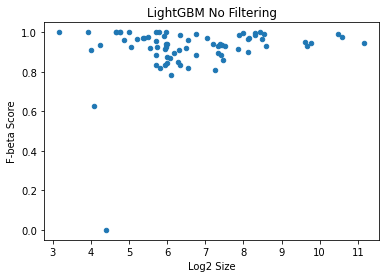

In [12]:
predictions = best.predict(x_val)
y_pred = []
for pred in predictions: 
    y_pred.append(np.argmax(pred))
cm = pd.DataFrame(metrics.confusion_matrix(y_val, y_pred))
new_cm = pd.DataFrame(columns = ["TN", "FP", "FN", "TP"])
for i in range(75):
    true_negative = 0
    for j in range(75):
        if j == i:
            continue
        true_negative += sum(cm[j][0:i].append(cm[j][i+1:]))
    new_cm.loc[i] = [true_negative, sum(cm[i][0:i].append(cm[i][i+1:])), sum(cm.iloc[i][0:i].append(cm.iloc[i][i+1:])), cm[i][i]]
labels = pd.read_csv("labels.csv")
labels.columns = ["Label", "Cluster"]
labels_dict = {}
for i in range(75):
    labels_dict[labels.iloc[i,1]] = i
dataset_sizes = pd.read_csv("subset sizes.csv", header = None)
cm = new_cm
cm["TN"] = cm["TN"].astype(np.int64)
cm["FP"] = cm["FP"].astype(np.int64)
cm["FN"] = cm["FN"].astype(np.int64)
cm["TP"] = cm["TP"].astype(np.int64)
cm = cm.assign(precision = cm["TP"] / (cm["TP"] + cm["FP"]))
cm["precision"].astype(np.float64)
cm = cm.assign(recall = cm["TP"] / (cm["TP"] + cm["FN"]))
cm["recall"].astype(np.float64)
cm = cm.assign(f1 = 2 * 1 / ((1 / cm["precision"]) + (1 / cm["recall"])))
cm = cm.assign(fbeta = (1 + 0.5 ** 2) * (cm["precision"] * cm["recall"]) / ((0.5 ** 2 * cm["precision"]) + cm["recall"]))
cm["fbeta"].fillna(0, inplace=True)
cm["cluster"] = labels["Cluster"]
cm = cm.merge(dataset_sizes, how = 'inner', left_on='cluster', right_on=0)
cm.drop(columns=0, inplace = True)
cm.rename(columns={1:"size"}, inplace = True)
cm["log_size"] = np.log2(cm["size"])
fig = cm.plot.scatter(x="log_size", y="fbeta", title="LightGBM No Filtering", ylim=[-0.05,1.05]).get_figure()
plt.xlabel("Log2 Size")
plt.ylabel("F-beta Score")

In [15]:
metrics.cohen_kappa_score(y_pred, y_val)

0.9457404468807059

In [18]:
cm.to_csv("./default and optimal/lgbm_optimal_validation_cov_2.5.csv")